## Predicting Store Sales using Machine Learning

In this notebook, we're going to go through an example machine learning project with the goal of predicting 
store sales.

## 1. Problem definition

> How well can we predict the future store sales given its past sales data?

## 2. Data

The data is downloaded from the Kaggle Store Sales - Time Series Forecasting competition: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

There are 6 main datasets.

## 3. Features: time-step feature and lag feature

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

In [ ]:
data_dir = Path('../input/ts-course-data/')
comp_dir = Path('../input/')

book_sales = pd.read_csv('store-sales-time-series-forecasting/book_sales.csv',
    index_col='Date',
    parse_dates=['Date'],
).drop('Paperback', axis=1)
book_sales['Time'] = np.arange(len(book_sales.index))
book_sales['Lag_1'] = book_sales['Hardcover'].shift(1)
book_sales = book_sales.reindex(columns=['Hardcover', 'Time', 'Lag_1'])

ar = pd.read_csv(data_dir / 'ar.csv')



In [3]:
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}

store_sales = pd.read_csv('store-sales-time-series-forecasting/train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

In [4]:
average_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
Freq: D, Name: sales, dtype: float32

### Fit a time-step feature

In [5]:
df = average_sales.to_frame()

# YOUR CODE HERE: Create a time dummy
time = np.arange(len(df.index))

df['time'] = time 

# YOUR CODE HERE: Create training data
X = df.loc[:, ['time']]  # features
y = df.loc[:, 'sales']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

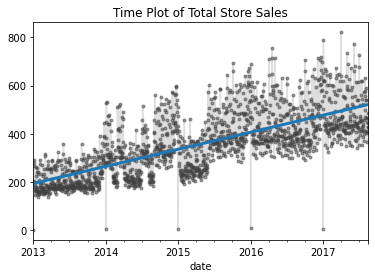

In [8]:
ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

### Fit a lag feature

In [9]:
df = average_sales.to_frame()

# YOUR CODE HERE: Create a lag feature from the target 'sales'
lag_1 = df['sales'].shift(1)

df['lag_1'] = lag_1  # add to dataframe

X = df.loc[:, ['lag_1']].dropna()  # features
y = df.loc[:, 'sales']  # target
y, X = y.align(X, join='inner')  # drop corresponding values in target

# YOUR CODE HERE: Create a LinearRegression instance and fit it to X and y.
model = LinearRegression().fit(X, y)

# YOUR CODE HERE: Create Store the fitted values as a time series with
# the same time index as the training data
y_pred = pd.Series(model.predict(X), index=X.index)

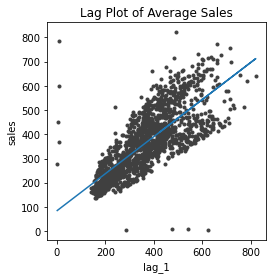

In [10]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');

## 4. Seasonality

In [11]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [12]:
holidays_events = pd.read_csv("store-sales-time-series-forecasting/holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

In [15]:
holidays_events.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [13]:
store_sales = pd.read_csv("store-sales-time-series-forecasting/train.csv",
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

In [14]:
store_sales.head()

,date,store_nbr,family,sales
0,2013-01-01,1,AUTOMOTIVE,0.0
1,2013-01-01,1,BABY CARE,0.0
2,2013-01-01,1,BEAUTY,0.0
3,2013-01-01,1,BEVERAGES,0.0
4,2013-01-01,1,BOOKS,0.0


In [16]:
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

In [17]:
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

In [19]:
average_sales.head()

date
2017-01-01      6.780303
2017-01-02    786.928406
2017-01-03    619.740234
2017-01-04    555.608032
2017-01-05    436.375397
Freq: D, Name: sales, dtype: float32

In [21]:
# define two functions: seasonal_plot and plot_periodogram
import seaborn as sns

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

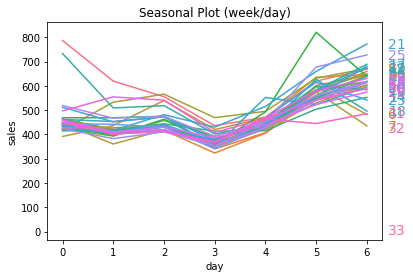

In [22]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

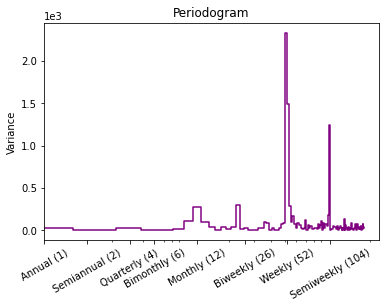

In [23]:
plot_periodogram(average_sales);

### (1) Determine seasonality

Both the seasonal plot and the periodogram suggest a **strong weekly seasonality**. 

From the periodogram, it appears there may be some **monthly** and **biweekly** components as well. In fact, the notes to the Store Sales dataset say wages in the public sector are paid out biweekly, on the 15th and last day of the month -- a possible origin for these seasons.

### (2) Create seasonal features¶
Use **DeterministicProcess** and **CalendarFourier** to create:

* indicators for weekly seasons and
* Fourier features of order 4 for monthly seasons.

In [24]:
y = average_sales.copy()

fourier = CalendarFourier(freq="M", order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,         
    additional_terms=[fourier], 
    drop=True,
)
X = dp.in_sample() 

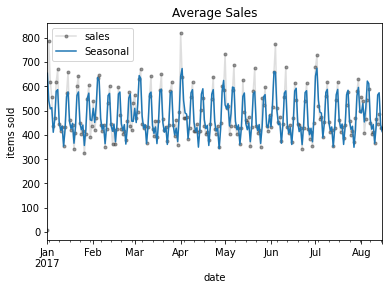

In [25]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

Removing from a series its trend or seasons is called **detrending** or **deseasonalizing** the series.

Look at the periodogram of the deseasonalized series.

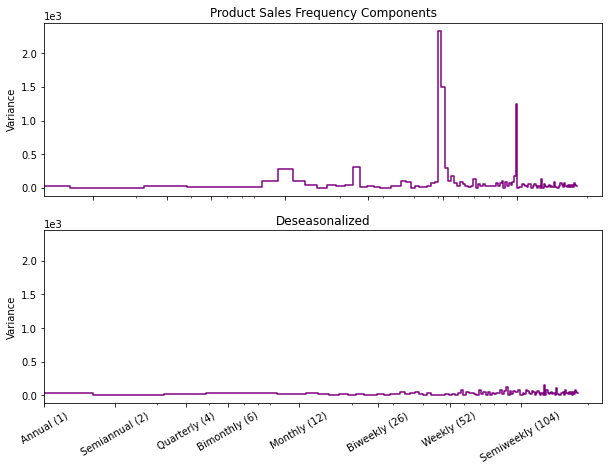

In [26]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

### (3) Check for remaining seasonality

The periodogram for the deseasonalized series lacks any large values. By comparing it to the periodogram for the original series, we can see that our model was able to capture the seasonal variation in Average Sales.

### (4) Seasonality for holidays

The Store Sales dataset includes a table of Ecuadorian holidays.

In [27]:
# National and regional holidays in the training set
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


From a plot of the deseasonalized Average Sales, it appears these holidays could have some predictive power.

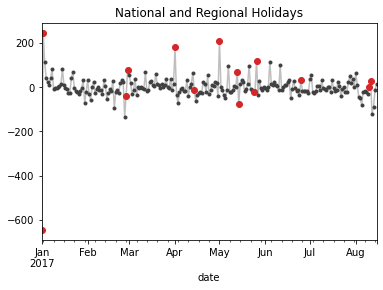

In [28]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays');

### (5) Create holiday features

In [ ]:
# Scikit-learn solution
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)

X_holidays = pd.DataFrame(
    ohe.fit_transform(holidays),
    index=holidays.index,
    columns=holidays.description.unique(),
)

In [29]:
# Pandas solution
X_holidays = pd.get_dummies(holidays)

In [30]:
# Join to training data
X2 = X.join(X_holidays, on='date').fillna(0.0)

In [31]:
X2.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,description_Dia de la Madre-1,description_Dia del Trabajo,description_Primer Grito de Independencia,description_Primer dia del ano,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Fit the seasonal model with holiday features added

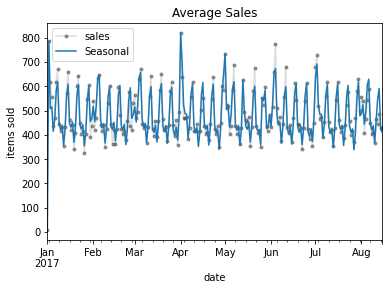

In [32]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X2), index=X2.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

### (6). New seasonal model for the competition

creates a seasonal model of the kind for the full Store Sales dataset with all 1800 time series

In [33]:
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [34]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'PRODUCE'
# Uncomment to see a list of product families
display(store_sales.index.get_level_values('family').unique())

CategoricalIndex(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
                  'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI',
                  'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II',
                  'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II',
                  'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR',
                  'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER',
                  'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES',
                  'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
                  'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
                 categories=['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', ...], ordered=False, name='family', dtype='category')

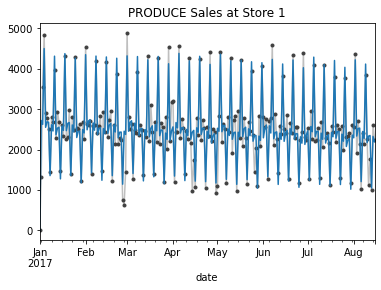

In [35]:
ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

### (7) Make predictions

Now load the test data, create a feature set for the forecast period, and then create the submission file `submission.csv`.

In [36]:
df_test = pd.read_csv('store-sales-time-series-forecasting/test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)


y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)